# 🏠 LSTM Model for Predicting Indoor Air Quality

This notebook builds and trains an LSTM model to forecast indoor temperature, humidity, PM2.5, and PM10 using both indoor and outdoor features.

**Targets:**
- Indoor temperature, humidity, PM2.5, PM10

**Inputs:**
- Past 6 hours of:
  - Indoor: temp, humidity, PM2.5, PM10
  - Outdoor: temp, humidity, PM2.5, PM10, wind_speed
  - Time: hour, day_of_week

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# 2. Load and preprocess data from CSVs
def load_combined_data_from_csv():
    sensor = pd.read_csv("data/SensorData.csv", parse_dates=['ts'])
    aqicn = pd.read_csv("data/project_aqicn.csv", parse_dates=['ts'])
    weather = pd.read_csv("data/project_weather.csv", parse_dates=['ts'])

    # Rename & select
    sensor = sensor.rename(columns={
        'temperature': 'temp_in', 'humidity': 'hum_in',
        'pm25': 'pm25_in', 'pm10': 'pm10_in'
    })[['ts', 'temp_in', 'hum_in', 'pm25_in', 'pm10_in']]

    aqicn = aqicn.rename(columns={'pm25': 'pm25_out', 'pm10': 'pm10_out'})[['ts', 'pm25_out', 'pm10_out']]
    weather = weather.rename(columns={'temperature': 'temp_out', 'humidity': 'hum_out'})[['ts', 'temp_out', 'hum_out', 'wind_speed']]

    # Set index and resample
    for df in [sensor, aqicn, weather]:
        df.set_index('ts', inplace=True)
        df.sort_index(inplace=True)

    sensor = sensor.resample('1h').mean()
    aqicn = aqicn.resample('1h').mean()
    weather = weather.resample('1h').mean()

    df = sensor.join(aqicn, how='inner').join(weather, how='inner')
    df = df.interpolate()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    return df

df = load_combined_data_from_csv()
print("✅ Shape:", df.shape)
df.tail()

✅ Shape: (564, 11)


,temp_in,hum_in,pm25_in,pm10_in,pm25_out,pm10_out,temp_out,hum_out,wind_speed,hour,day_of_week
ts,,,,,,,,,,,
2025-04-21 08:00:00,32.0,62.166667,24.666667,25.000000,56.0,25.0,31.66,82.0,4.63,8,0
2025-04-21 09:00:00,32.0,62.000000,18.166667,18.333333,52.0,23.0,32.38,73.0,4.74,9,0
2025-04-21 10:00:00,32.0,61.000000,16.666667,17.333333,59.0,23.0,33.41,64.0,4.82,10,0
2025-04-21 11:00:00,32.0,59.666667,14.833333,15.000000,79.0,30.0,33.85,61.0,4.90,11,0
2025-04-21 12:00:00,32.0,58.750000,18.000000,18.500000,69.0,37.0,34.51,61.0,5.21,12,0


In [3]:
# 3. Scale & create sequences
target_cols = ['temp_in', 'hum_in', 'pm25_in', 'pm10_in']
feature_cols = df.columns.tolist()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=feature_cols)

def create_sequences(data, target_cols, n_steps=12):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i][target_cols].values)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, target_cols)

# Remove NaN sequences
mask = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y).any(axis=1)
X, y = X[mask], y[mask]

X.shape, y.shape

((552, 12, 11), (552, 4))

In [4]:
# 4. Train/test split
split = int(len(X) * 0.85)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
# 5. Train LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dense(len(target_cols)))
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)

Epoch 1/100


c:\Users\taroo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2054 - val_loss: 0.0435
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0334 - val_loss: 0.0352
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - val_loss: 0.0183
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164 - val_loss: 0.0169
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - val_loss: 0.0130
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - val_loss: 0.0105
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0111
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - val_l

In [6]:
# 6. Evaluate model
pred = model.predict(X_test)

# Inverse scale
zeros = np.zeros((pred.shape[0], len(feature_cols) - len(target_cols)))
pred_inv = scaler.inverse_transform(np.hstack([pred, zeros]))[:, :len(target_cols)]
y_test_inv = scaler.inverse_transform(np.hstack([y_test, zeros]))[:, :len(target_cols)]

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv, multioutput='raw_values'))
mae = mean_absolute_error(y_test_inv, pred_inv, multioutput='raw_values')

for i, col in enumerate(target_cols):
    print(f"🔍 {col.upper()} → RMSE: {rmse[i]:.3f}, MAE: {mae[i]:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🔍 TEMP_IN → RMSE: 0.244, MAE: 0.193
🔍 HUM_IN → RMSE: 0.942, MAE: 0.661
🔍 PM25_IN → RMSE: 5.144, MAE: 3.155
🔍 PM10_IN → RMSE: 6.503, MAE: 3.064


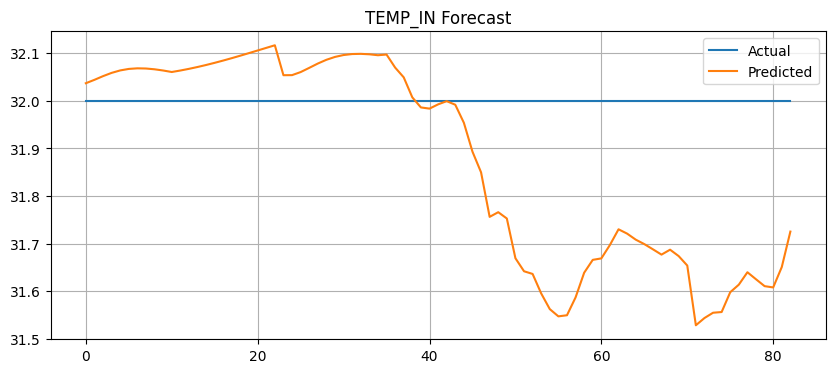

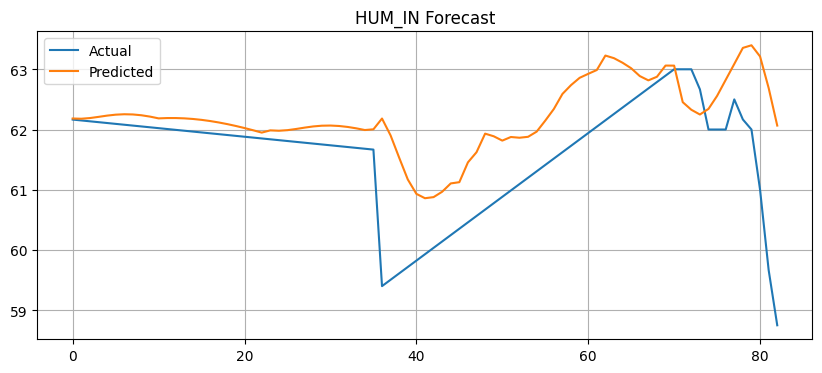

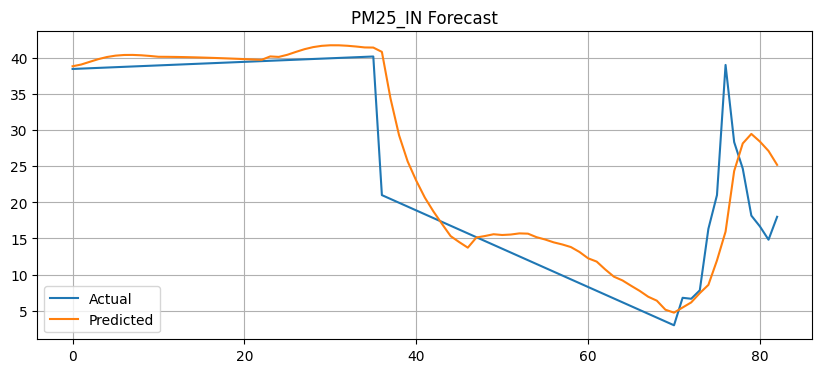

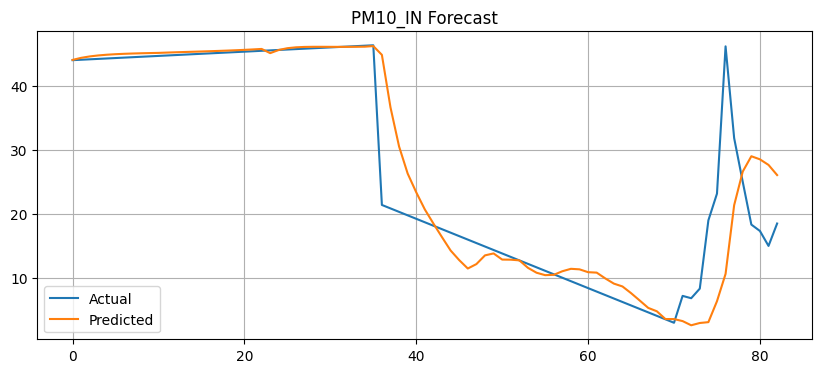

In [7]:
# 7. Plot predicted vs actual
for i, col in enumerate(target_cols):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv[:, i], label='Actual')
    plt.plot(pred_inv[:, i], label='Predicted')
    plt.title(f"{col.upper()} Forecast")
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
# 8. Forecast next 24 hours
n_forecast = 24
last_sequence = scaled_df[-6:].copy()
forecast_scaled = []

for _ in range(n_forecast):
    input_seq = np.expand_dims(last_sequence.values, axis=0)
    next_pred = model.predict(input_seq)[0]
    padded = np.concatenate([
        next_pred,
        last_sequence.iloc[-1][[col for col in feature_cols if col not in target_cols]].values
    ])
    forecast_scaled.append(padded[:len(target_cols)])

    new_df = pd.DataFrame([padded], columns=feature_cols)
    last_sequence = pd.concat([last_sequence, new_df], ignore_index=True).iloc[1:]

forecast_scaled = np.array(forecast_scaled)
forecast_inverse = scaler.inverse_transform(
    np.hstack([forecast_scaled, np.zeros((n_forecast, len(feature_cols) - len(target_cols)))])
)[:, :len(target_cols)]

forecast_df = pd.DataFrame(forecast_inverse, columns=target_cols)
forecast_df['time'] = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')
forecast_df.set_index('time', inplace=True)
forecast_df.tail()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\taroo\AppData\Local\Temp\ipykernel_71024\638319914.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_df['time'] = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')


,temp_in,hum_in,pm25_in,pm10_in
time,,,,
2025-04-22 08:00:00,31.132391,58.445048,5.652616,0.370206
2025-04-22 09:00:00,31.126625,58.454852,5.535099,0.257400
2025-04-22 10:00:00,31.121644,58.463718,5.433722,0.160671
2025-04-22 11:00:00,31.117346,58.471695,5.346321,0.077738
2025-04-22 12:00:00,31.113641,58.478840,5.271017,0.006639


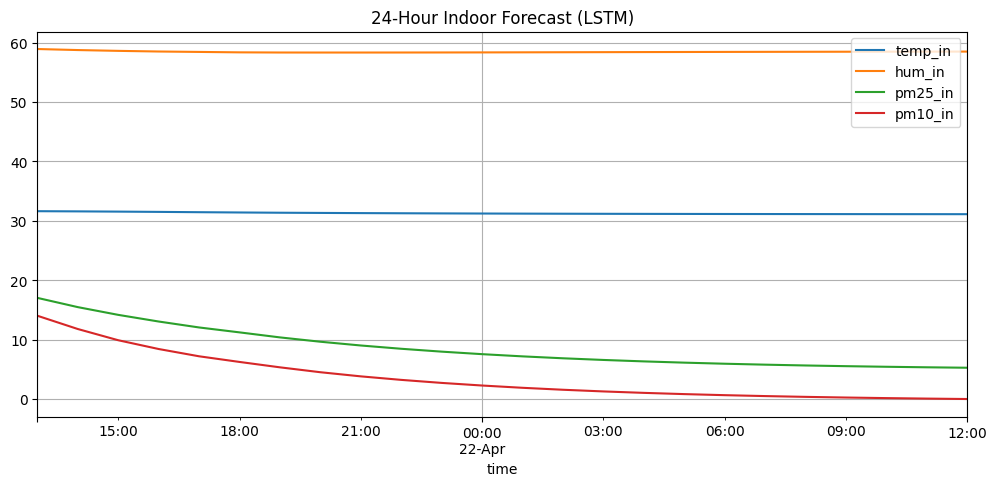

In [9]:
# 9. Plot 24-hour forecast
forecast_df.plot(title="24-Hour Indoor Forecast (LSTM)", figsize=(12, 5))
plt.grid()
plt.show()